# Notebook to calculate total kinetic energy dissipation rate $\epsilon$ for ROMS model output. 
The equation depends on the turbulence closure scheme used, which can be assessed from the output or log files. 
See the figure below from Warner et al. (2005) OM doi:10.1016/j.ocemod.2003.12.003 for more information. <br>
<img src="warner_2005.png" alt="isolated" width="600"/>
<br>
## $\epsilon$ is modeled after Eq. 12: $\epsilon = (c_{\mu}^0)^{3+p/n}k^{3/2+m/n} \psi^{-1/n}$
Based on the table, we can use the "p" variable to differentiate the GLS schemes to check out work. 

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt

/d2/home/dylan/.conda/envs/txla_model/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


# Open output files from hafen

In [2]:
paths = ['https://hafen.geos.tamu.edu/thredds/dodsC/NcML/txla_nest_p_his_2021_v2_agg', # Parent, his file
         'https://hafen.geos.tamu.edu/thredds/dodsC/NcML/txla_nest_p_avg_2021_v2_agg'] # Parent, avg file

def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    return ds1, grid1

ds = []
grid = []
for i in range(len(paths)):
    ds1, grid1 = open_roms(paths[i])
    ds.append(ds1)
    grid.append(grid1)

In [3]:
def calc_epsilon(ds, grid):
    '''
Function to calculate TKE dissipation rate for GLS models based on Eq. 12 of Warner
et al. (2005) ocean modeling
    '''
    cmu0 = ds.gls_cmu0
    gls_m = ds.gls_m
    gls_n = ds.gls_n
    gls_p = ds.gls_p

    tke = ds.tke
    gls = ds.gls
    
    epsilon_w = cmu0**(3.0+gls_p/gls_n) * tke**(3.0/2.0+gls_m/gls_n) * gls**(-1.0/gls_n)
   # epsilon = grid.interp(epsilon_w, 'Z') #Interpolate to the w points 
    return epsilon

## Make a simple cross-section plot at a random time to test calculations. 
Draw from 'make_plots.ipynb' for context 

In [4]:
# Example of how to slice it with a box, but this won't work for the current model output as it is outside the grid 
# lon = np.array([-93,-92])
# lat = np.array([28,29.4])
# box1 = ((lon[0] < ds[0].lon_rho) & (ds[0].lon_rho < lon[1]) & (lat[0] < ds[0].lat_rho) & (ds[0].lat_rho < lat[1])).compute()

epsilon = calc_epsilon(ds[0], grid[0])
epsilon_cs = epsilon.isel(ocean_time = 100, xi_rho = 250)
epsilon_cs1 = epsilon_cs.assign_coords({'lat_rho':ds[0].lat_rho.isel(xi_rho = 250),
                                        'z_rho':(ds[0].z_rho.isel(ocean_time = 100).isel(xi_rho = 250))}).load()
epsilon_cs1

<xarray.DataArray (s_rho: 30, eta_rho: 191)>
array([[1.56263434e-07, 1.56263434e-07, 1.11076963e-07, ...,
        6.05953152e-13, 6.05953152e-13, 0.00000000e+00],
       [5.24900244e-13, 5.24900244e-13, 5.29204836e-13, ...,
        4.39276505e-13, 4.39276505e-13, 0.00000000e+00],
       [5.52581632e-13, 5.52581632e-13, 5.52401284e-13, ...,
        2.48277758e-13, 2.48277758e-13, 0.00000000e+00],
       ...,
       [5.34987631e-12, 5.34987631e-12, 5.43600344e-12, ...,
        1.22679588e-12, 1.22679588e-12, 0.00000000e+00],
       [2.45477035e-10, 2.45477035e-10, 5.99164873e-10, ...,
        2.22225025e-12, 2.22225025e-12, 0.00000000e+00],
       [2.82305600e-06, 2.82305600e-06, 2.78395849e-06, ...,
        1.77879886e-12, 1.77879886e-12, 0.00000000e+00]])
Coordinates:
    ocean_time  datetime64[ns] 2021-06-15T04:00:00
    xi_rho      int64 250
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 184 185 186 187 188 189 190
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_rho     (eta_rho) float64 -94.28 -94.29 -94.29 ... -95.54 -95.55 -95.56
    lat_rho     (eta_rho) float64 27.3 27.31 27.33 27.34 ... 29.41 29.42 29.43
    z_rho       (s_rho, eta_rho) float64 -1.125e+03 -1.121e+03 ... nan nan
Attributes:
    long_name:  stability coefficient

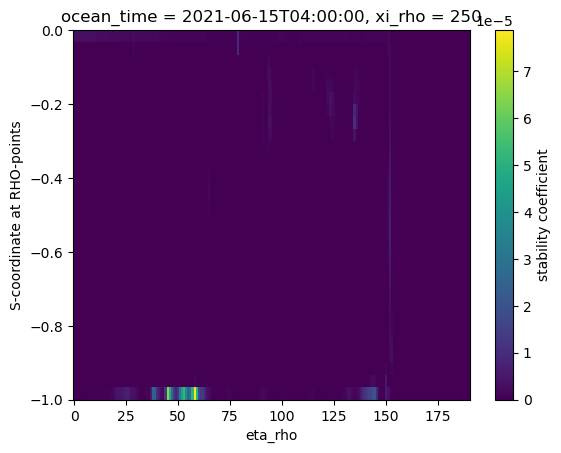

In [6]:
epsilon_cs1.plot()

/d2/home/dylan/.conda/envs/txla_model/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

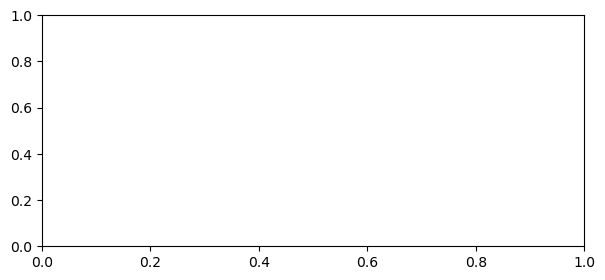

In [7]:
fig, ax = plt.subplots(1,1, figsize = (7,3))

np.log10(np.log10(epsilon_cs1)).plot(ax = ax, x = 'lat_rho', y = 'z_rho', cmap = cmo.matter, vmin = -8, vmax = -5)

### Interesting error code, let's naively fill with zeros and see if that fixes the problem 

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

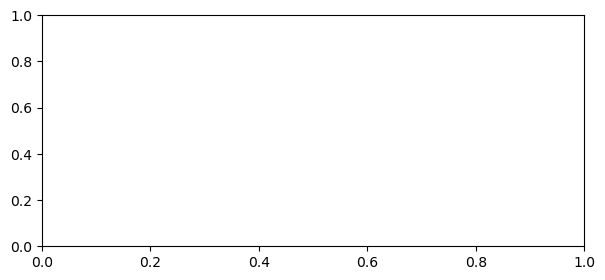

In [23]:
import numpy.ma as ma
Zm = (epsilon_cs1).fillna(0)

fig, ax = plt.subplots(1,1, figsize = (7,3))
np.log10(Zm).plot(ax = ax, x = 'lat_rho', y = 'z_rho', cmap = cmo.matter, vmin = -8, vmax = -5)

### Didn't work, where are the NaNs? 

In [25]:
Zm

<xarray.DataArray (s_rho: 30, eta_rho: 191)>
array([[1.56263434e-07, 1.56263434e-07, 1.11076963e-07, ...,
        6.05953152e-13, 6.05953152e-13, 0.00000000e+00],
       [5.24900244e-13, 5.24900244e-13, 5.29204836e-13, ...,
        4.39276505e-13, 4.39276505e-13, 0.00000000e+00],
       [5.52581632e-13, 5.52581632e-13, 5.52401284e-13, ...,
        2.48277758e-13, 2.48277758e-13, 0.00000000e+00],
       ...,
       [5.34987631e-12, 5.34987631e-12, 5.43600344e-12, ...,
        1.22679588e-12, 1.22679588e-12, 0.00000000e+00],
       [2.45477035e-10, 2.45477035e-10, 5.99164873e-10, ...,
        2.22225025e-12, 2.22225025e-12, 0.00000000e+00],
       [2.82305600e-06, 2.82305600e-06, 2.78395849e-06, ...,
        1.77879886e-12, 1.77879886e-12, 0.00000000e+00]])
Coordinates:
    ocean_time  datetime64[ns] 2021-06-15T04:00:00
    xi_rho      int64 250
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 184 185 186 187 188 189 190
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_rho     (eta_rho) float64 -94.28 -94.29 -94.29 ... -95.54 -95.55 -95.56
    lat_rho     (eta_rho) float64 27.3 27.31 27.33 27.34 ... 29.41 29.42 29.43
    z_rho       (s_rho, eta_rho) float64 -1.125e+03 -1.121e+03 ... nan nan
Attributes:
    long_name:  stability coefficient

### Ah, the problem is the z_rho coordinate. Let's fix that and retry 

In [27]:
epsilon = calc_epsilon(ds[0], grid[0])
z_rho = ds[0].z_rho.isel(ocean_time = 100).isel(xi_rho = 250).fillna(0)

epsilon_cs = epsilon.isel(ocean_time = 100, xi_rho = 250)
epsilon_cs1 = epsilon_cs.assign_coords({'lat_rho':ds[0].lat_rho.isel(xi_rho = 250),
                                        'z_rho':z_rho}).load()
epsilon_cs1

<xarray.DataArray (s_rho: 30, eta_rho: 191)>
array([[1.56263434e-07, 1.56263434e-07, 1.11076963e-07, ...,
        6.05953152e-13, 6.05953152e-13, 0.00000000e+00],
       [5.24900244e-13, 5.24900244e-13, 5.29204836e-13, ...,
        4.39276505e-13, 4.39276505e-13, 0.00000000e+00],
       [5.52581632e-13, 5.52581632e-13, 5.52401284e-13, ...,
        2.48277758e-13, 2.48277758e-13, 0.00000000e+00],
       ...,
       [5.34987631e-12, 5.34987631e-12, 5.43600344e-12, ...,
        1.22679588e-12, 1.22679588e-12, 0.00000000e+00],
       [2.45477035e-10, 2.45477035e-10, 5.99164873e-10, ...,
        2.22225025e-12, 2.22225025e-12, 0.00000000e+00],
       [2.82305600e-06, 2.82305600e-06, 2.78395849e-06, ...,
        1.77879886e-12, 1.77879886e-12, 0.00000000e+00]])
Coordinates:
    ocean_time  datetime64[ns] 2021-06-15T04:00:00
    xi_rho      int64 250
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 184 185 186 187 188 189 190
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_rho     (eta_rho) float64 -94.28 -94.29 -94.29 ... -95.54 -95.55 -95.56
    lat_rho     (eta_rho) float64 27.3 27.31 27.33 27.34 ... 29.41 29.42 29.43
    z_rho       (s_rho, eta_rho) float64 -1.125e+03 -1.121e+03 ... 0.0 0.0
Attributes:
    long_name:  stability coefficient

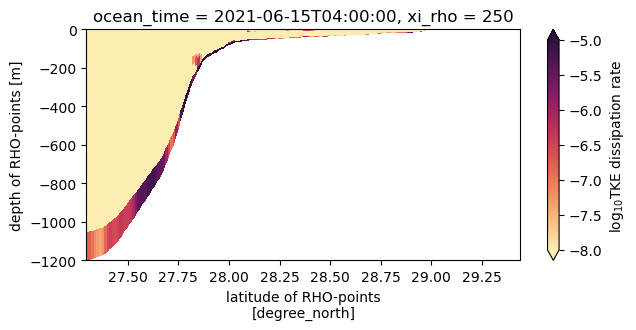

In [29]:
Zm = (epsilon_cs1).fillna(0)

fig, ax = plt.subplots(1,1, figsize = (7,3))
np.log10(Zm).plot(ax = ax, x = 'lat_rho', y = 'z_rho', 
                  cmap = cmo.matter, vmin = -8, vmax = -5,
                  cbar_kwargs = {'label':'log$_{10}$TKE dissipation rate'})

### Seriously elevated bottom mixing, which is ok.
Not sure exactly what the cause is though. 